In [ ]:
!pip install pandas numpy tensorflow scikit-learn pickle-mixin

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

# Step 1: Load Dataset
file_path = "expanded_dataset.csv"  # Update the correct path
df = pd.read_csv(file_path)

# Step 2: Data Preprocessing
df.dropna(inplace=True)  # Remove any missing values

# Check dataset structure
print(df.head())

# Assuming dataset has 'text', 'sentiment', 'emotion' columns
texts = df['text'].astype(str).values
sentiments = df['sentiment'].values
emotions = df['emotions'].values

# Step 3: Encode Sentiment Labels
sentiment_encoder = LabelEncoder()
sentiments_encoded = sentiment_encoder.fit_transform(sentiments)

# Encode Emotion Labels
emotion_encoder = LabelEncoder()
emotions_encoded = emotion_encoder.fit_transform(emotions)

# Step 4: Tokenization & Padding
vocab_size = 10000  # Adjust based on dataset
max_length = 100  # Truncate or pad to 100 words
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')



# Save sentiment label encoder
with open("sentiment_encoder.pkl", "wb") as f:
    pickle.dump(sentiment_encoder, f)

# Save emotion label encoder
with open("emotion_encoder.pkl", "wb") as f:
    pickle.dump(emotion_encoder, f)

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Encoders and tokenizer saved successfully!")


ModuleNotFoundError: No module named 'pandas'

In [ ]:

# Step 5: Train-Test Split
X_train, X_test, y_train_sent, y_test_sent = train_test_split(padded_sequences, sentiments_encoded, test_size=0.2, random_state=42)
X_train, X_test, y_train_emotion, y_test_emotion = train_test_split(padded_sequences, emotions_encoded, test_size=0.2, random_state=42)

# Step 6: Build LSTM Model
def build_lstm_model(output_dim):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')  # Softmax for multi-class classification
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Step 7: Train Sentiment Model
model_sentiment = build_lstm_model(len(sentiment_encoder.classes_))
model_sentiment.fit(X_train, y_train_sent, epochs=5, batch_size=64, validation_data=(X_test, y_test_sent))

# Step 8: Train Emotion Model
model_emotion = build_lstm_model(len(emotion_encoder.classes_))
model_emotion.fit(X_train, y_train_emotion, epochs=5, batch_size=64, validation_data=(X_test, y_test_emotion))

# Step 9: Evaluate the Models
sentiment_loss, sentiment_acc = model_sentiment.evaluate(X_test, y_test_sent)
emotion_loss, emotion_acc = model_emotion.evaluate(X_test, y_test_emotion)

print(f"Sentiment Model Accuracy: {sentiment_acc:.4f}")
print(f"Emotion Model Accuracy: {emotion_acc:.4f}")

# Step 10: Save the Models
model_sentiment.save("sentiment_model.h5")
model_emotion.save("emotion_model.h5")

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

# Load Saved Models
model_sentiment = tf.keras.models.load_model("/content/sentiment_model.h5")
model_emotion = tf.keras.models.load_model("/content/emotion_model.h5")


# Function to Predict Sentiment & Emotion
def predict_text(text):
    # Tokenize & Pad Input
    max_length = 100
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict Sentiment
    sentiment_pred = model_sentiment.predict(padded_sequence)
    sentiment_label = sentiment_encoder.inverse_transform([np.argmax(sentiment_pred)])[0]

    # Predict Emotion
    emotion_pred = model_emotion.predict(padded_sequence)
    emotion_label = emotion_encoder.inverse_transform([np.argmax(emotion_pred)])[0]

    return sentiment_label, emotion_label

# Example Prediction
text = input("Enter a text for analysis: ")
sentiment, emotion = predict_text(text)

print(f"Predicted Sentiment: {sentiment}")
print(f"Predicted Emotion: {emotion}")

Enter a text for analysis: i love this product
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Predicted Sentiment: positive
Predicted Emotion: grateful


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

# Load Saved Models
model_sentiment = tf.keras.models.load_model("sentiment_model.h5")
model_emotion = tf.keras.models.load_model("emotion_model.h5")

# Function to Predict Sentiment & Emotion
def predict_text(text):
    # Tokenize & Pad Input
    max_length = 100
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict Sentiment
    sentiment_pred = model_sentiment.predict(padded_sequence)
    sentiment_label = sentiment_encoder.inverse_transform([np.argmax(sentiment_pred)])[0]

    # Predict Emotion
    emotion_pred = model_emotion.predict(padded_sequence)
    emotion_label = emotion_encoder.inverse_transform([np.argmax(emotion_pred)])[0]

    return sentiment_label, emotion_label

# Gradio Interface
demo = gr.Interface(
    fn=predict_text,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=[gr.Textbox(label="Predicted Sentiment"), gr.Textbox(label="Predicted Emotion")]
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://02e9abf6e19a65df9f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


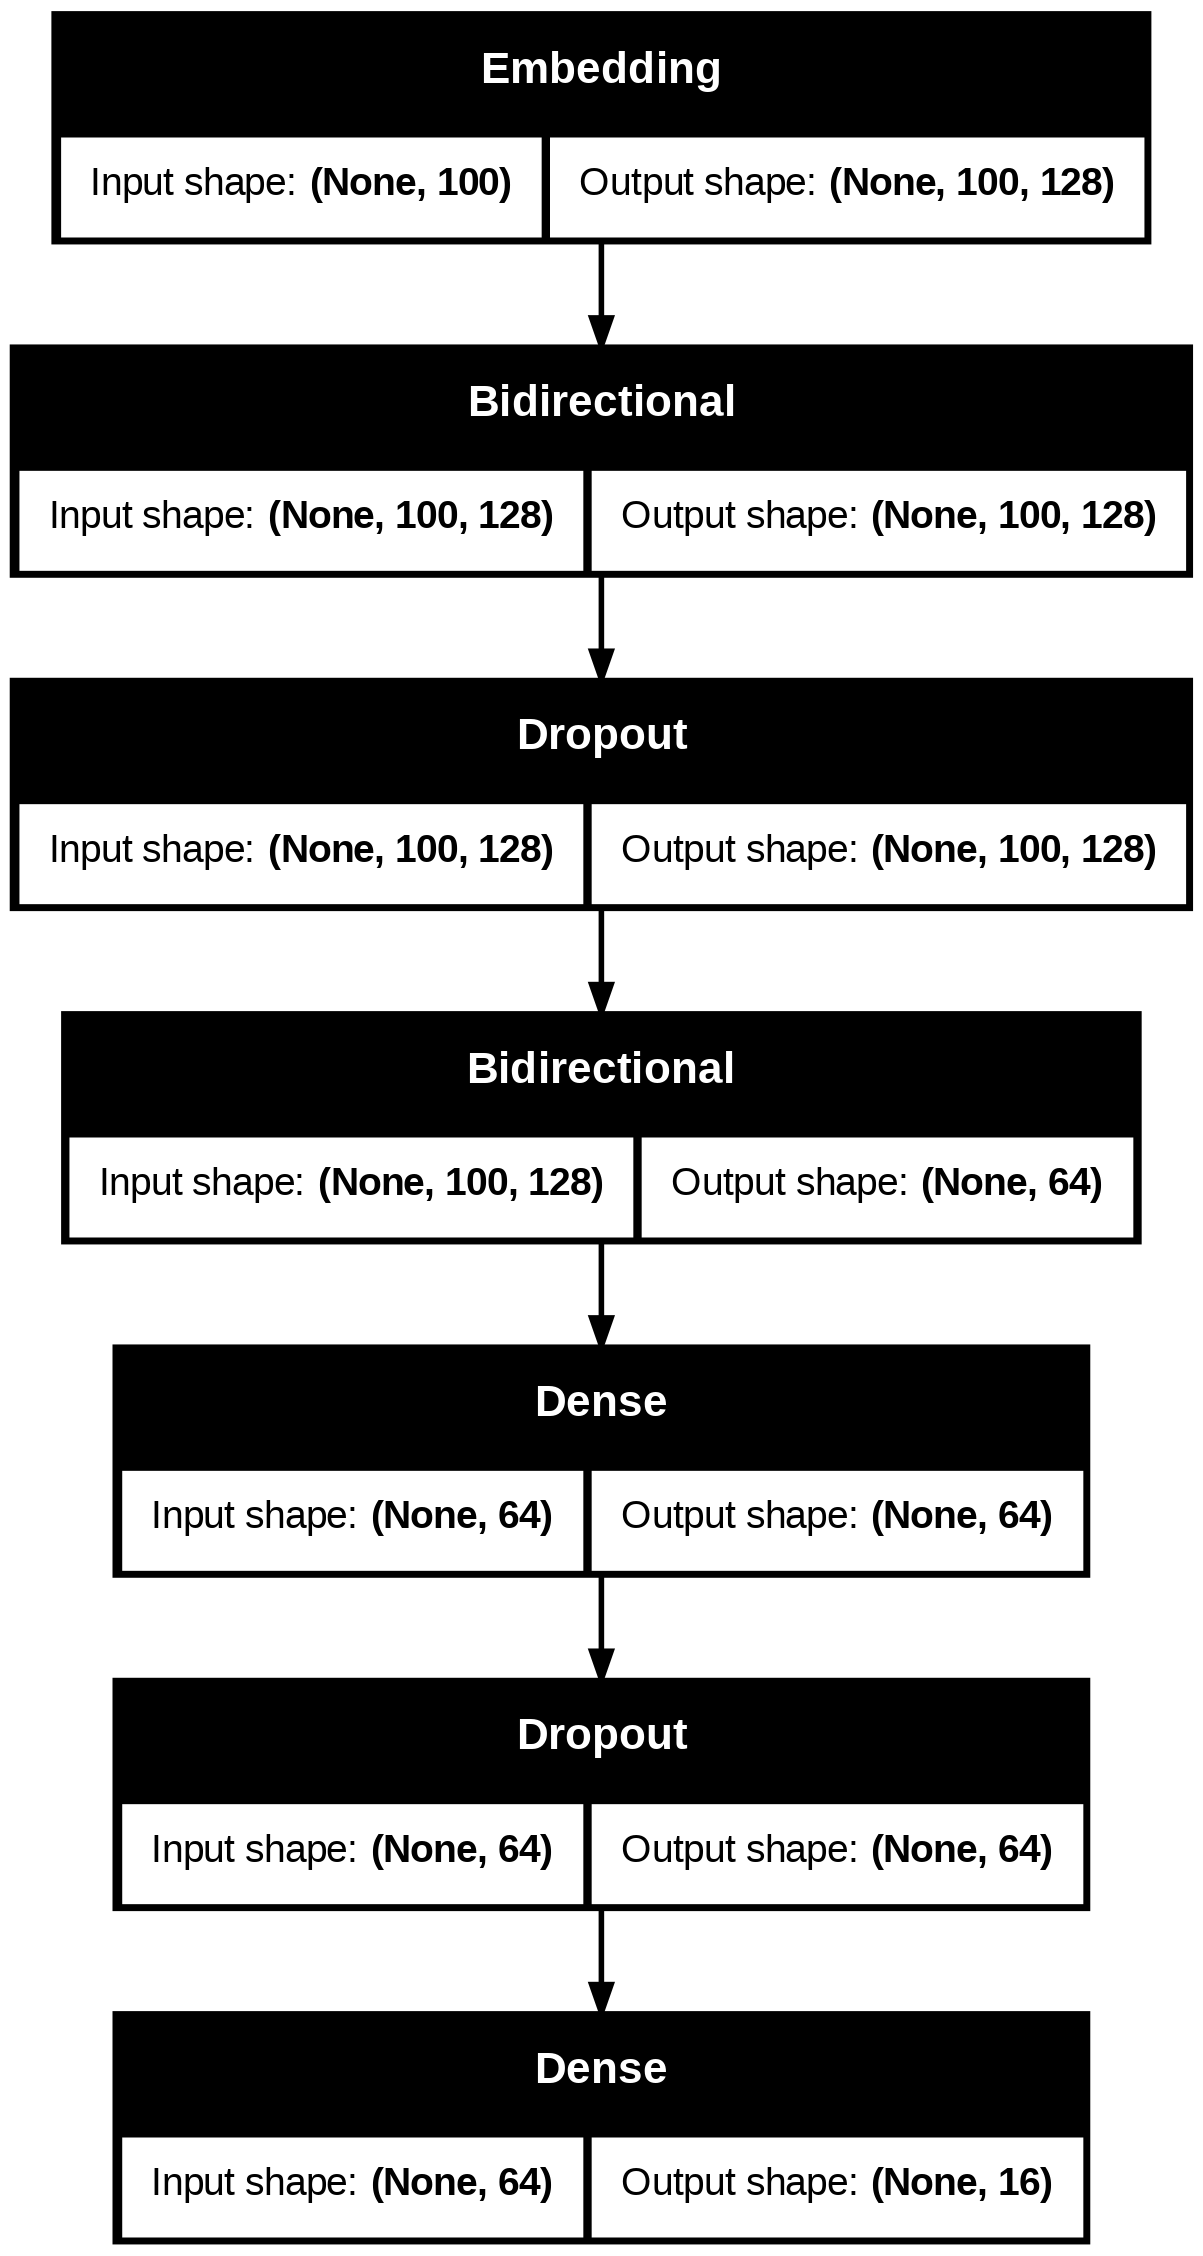

In [4]:

import tensorflow as tf
tf.keras.utils.plot_model(model_sentiment, show_shapes=True)
tf.keras.utils.plot_model(model_emotion, show_shapes=True)
